In [1]:
train_dir = '../input/covidnew/ALL' 
val_dir = '../input/covidnew/ALL' 
test_dir = '../input/covidnew/ALL'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
#(224, 224, 3)
ih, iw = 100, 100 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size


In [6]:
#LEEMOS LAS IMÁGENES 
from keras.applications.imagenet_utils import preprocess_input
img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    subset='validation',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = val_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    subset='validation',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 15861 images belonging to 2 classes.
Found 6796 images belonging to 2 classes.
Found 4531 images belonging to 2 classes.


In [7]:
train=train_generator
val=validation_generator
test=test_generator

In [8]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 


vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-5].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 

 
vgg_model.trainable = True 
#set_trainable = False
 
#for layer in vgg_model.layers: 
#    if layer.name in ['block5_conv1', 'block4_conv1']: 
#        set_trainable = True 
#    if set_trainable: 
#        layer.trainable = True 
#    else: 
#        layer.trainable = False 

2023-01-28 18:49:09.356824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 18:49:09.456589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 18:49:09.457341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 18:49:09.458683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 3s 0us/step


In [9]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fb143a5fc50>,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0x7fb141eb8e50>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x7fb140853490>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x7fb141eda810>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x7fb140853150>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x7fb141eeb5d0>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7fb141eebdd0>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x7fb141ef2410>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x7fb1421fc4d0>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x7fb141ef2110>,block3_conv3,True


In [11]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
# from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [12]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers  
import tensorflow as tf

# build model architecture 
model = Sequential() 

model.add(vgg_model) 
model.add(Dense(1024, activation='relu', input_dim=input_shape)) 
#model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(num_class, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 18432)             7635264   
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 27,167,298
Trainable params: 27,167,298
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val,   
                              verbose=1)

Epoch 1/10
496/496 [==============================] - 121s 244ms/step - loss: 0.1893 - accuracy: 0.9235 - f1_m: 0.9216 - precision_m: 0.9141 - recall_m: 0.9304 - val_loss: 0.1131 - val_accuracy: 0.9531 - val_f1_m: 0.9504 - val_precision_m: 0.9564 - val_recall_m: 0.9453
Epoch 2/10
496/496 [==============================] - 40s 81ms/step - loss: 0.0864 - accuracy: 0.9694 - f1_m: 0.9671 - precision_m: 0.9666 - recall_m: 0.9680 - val_loss: 0.0861 - val_accuracy: 0.9570 - val_f1_m: 0.9527 - val_precision_m: 0.9564 - val_recall_m: 0.9492
Epoch 3/10
496/496 [==============================] - 40s 81ms/step - loss: 0.0551 - accuracy: 0.9800 - f1_m: 0.9789 - precision_m: 0.9794 - recall_m: 0.9786 - val_loss: 0.0528 - val_accuracy: 0.9766 - val_f1_m: 0.9764 - val_precision_m: 0.9846 - val_recall_m: 0.9688
Epoch 4/10
496/496 [==============================] - 41s 82ms/step - loss: 0.0328 - accuracy: 0.9890 - f1_m: 0.9878 - precision_m: 0.9886 - recall_m: 0.9871 - val_loss: 0.0779 - val_accuracy: 0

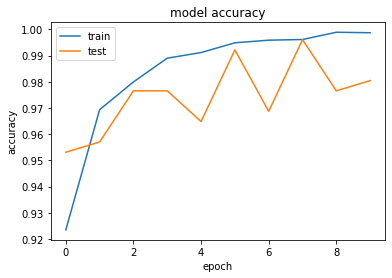

In [17]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

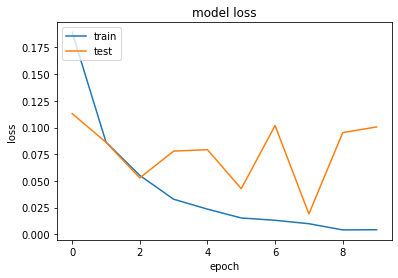

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

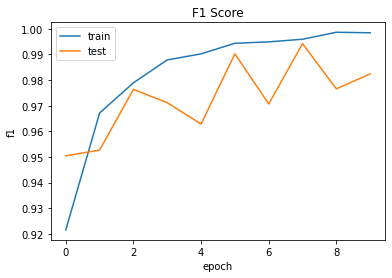

In [19]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

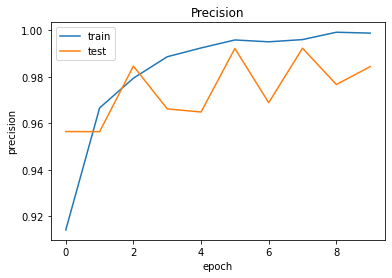

In [20]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

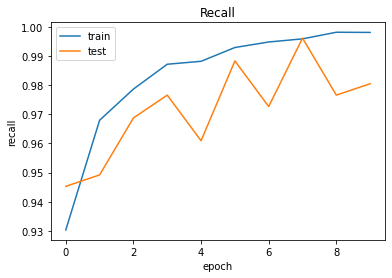

In [21]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

142/142 [==============================] - 27s 188ms/step - loss: 0.0858 - accuracy: 0.9788 - f1_m: 0.9782 - precision_m: 0.9810 - recall_m: 0.9756
El modelo predice el  97.88126349449158 % de los datos


In [23]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'

In [ ]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

In [ ]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

In [ ]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

In [ ]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

In [ ]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

In [ ]:
pred=model.predict(articulo)

In [ ]:
#Aquí sólo hago con  un predict con el modelo y los datos del artículo
import numpy as np
suma=0
for i in range (351):
    if np.argmax(pred[i])==0:
        suma=suma+1
print(suma)